In [1]:
import MDAnalysis as mda
from numpy import *
import os
from pylab import *
import MDAnalysis.analysis.distances
import MDAnalysis.analysis.rms
from MDAnalysis.analysis import align
import glob
#import umap
import scipy.stats
import sklearn
import sklearn.decomposition
import sklearn.preprocessing
import mdtraj
import pandas as pd
import seaborn as sns
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [2]:
twoColour=["#332288","#882255"]
# Dark green,    
#sixColor=['#0A732D','#332288','#88CCEE',"#44AA99",'#882255','#D250BC']
#colorScheme=sixColor
colourScheme = twoColour
system_names = ['No-PEG','PEG']


In [3]:
EQPOINT=250



h2opath="data/water/solvent_included/"
pegpath="data/peg/solvent_included/"

#glob tprs
h2ogros=glob.glob(h2opath+"*.gro")
peggros=glob.glob(pegpath+"*.gro")

#glob tprs
h2otprs=glob.glob(h2opath+"*.tpr")
pegtprs=glob.glob(pegpath+"*.tpr")

#trjs
h2otrjs=glob.glob(h2opath+"*.xtc")
pegtrjs=glob.glob(pegpath+"*.xtc")

systemtprs=[h2otprs,pegtprs]
systemtrjs=[h2otrjs,pegtrjs]


resids_proper_mdtraj=list(arange(-4,66))+list(arange(69,238))
resids_mdtraj=list(arange(-4,66))+[nan,nan,nan]+list(arange(69,238))

resids_proper=list(arange(-4,67))+list(arange(69,238))
resids=list(arange(-4,67))+[nan,nan]+list(arange(69,238))



def fix_mdtraj_dssp(gro,trj):
    u = mda.Universe(gro,trj)
    hsds=where(u.residues.resnames=="HSD")[0]
    for i in range(len(hsds)):
        u.residues[hsds[i]].resname = 'HIS'

    new_gro = "data/"+gro.split("/")[-3]+"/mdtraj/"+gro.split("/")[-1][:-4]+"_mdtraj.gro"
    new_trj = "data/"+trj.split("/")[-3]+"/mdtraj/"+trj.split("/")[-1][:-4]+"_mdtraj.xtc"

    protein = u.select_atoms("protein")
    protein.write(new_gro)
    with mda.Writer(new_trj, protein.n_atoms) as W:
        for ts in u.trajectory:
            W.write(protein)
            
for i in range(len(systemtprs)):
    for j in range(len(systemtprs[i])):
        fix_mdtraj_dssp(systemtprs[i][j],systemtrjs[i][j])


h2opath_mdtraj="data/water/mdtraj/"
pegpath_mdtraj="data/peg/mdtraj/"

#glob tprs
h2ogros_mdtraj=glob.glob(h2opath_mdtraj+"*.gro")
peggros_mdtraj=glob.glob(pegpath_mdtraj+"*.gro")


#trjs
h2otrjs_mdtraj=glob.glob(h2opath_mdtraj+"*.xtc")
pegtrjs_mdtraj=glob.glob(pegpath_mdtraj+"*.xtc")

systemtprs_mdtraj=[h2ogros_mdtraj,peggros_mdtraj]
systemtrjs_mdtraj=[h2otrjs_mdtraj,pegtrjs_mdtraj]

systems_mdtraj = []
for i in range(len(systemtprs_mdtraj)):
    sub=[]
    for j in range(len(systemtprs_mdtraj[i])):
        sub.append(mda.Universe(systemtprs_mdtraj[i][j],systemtrjs_mdtraj[i][j]))
    systems_mdtraj.append(sub)

/home/liam/.local/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py:237: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [4]:
def getSSByRes(trjpaths,tprpaths,EQPOINT):
    
    helicityMap={"H":1,"E":0,"C":0}
    betacityMap={"H":0,"E":1,"C":0}
    coilicityMap={"H":0,"E":0,"C":1}
    
    helicity= []
    betacity= []
    coilicity=[]
    
    herr=[]
    berr=[]
    cerr=[]
    
    for i in range(len(trjpaths)):
        subH=[]
        subE=[]
        subC=[]
        for j in range(len(trjpaths[i])):
            t=mdtraj.load(trjpaths[i][j],top=tprpaths[i][j])
            ss1=mdtraj.compute_dssp(t,simplified=True)
            H1=zeros(ss1.shape)
            E1=zeros(ss1.shape)
            C1=zeros(ss1.shape)
            
            for ii in range(len(H1)):
                for jj in range(len(H1[ii])):
                    H1[ii][jj]=helicityMap[ss1[ii][jj]]
                    E1[ii][jj]=betacityMap[ss1[ii][jj]]
                    C1[ii][jj]=coilicityMap[ss1[ii][jj]]
                    
            H1byRes=mean(H1[EQPOINT:],axis=0)
            subH.append(H1byRes)
            
            E1byRes=mean(E1[EQPOINT:],axis=0)
            subE.append(E1byRes)
            C1byRes=mean(C1[EQPOINT:],axis=0)
            subC.append(C1byRes)
            
        helicity.append(subH)
        betacity.append(subE)
        coilicity.append(subC)

    return helicity,betacity,coilicity


helicity,betacity,coilicity=getSSByRes(systemtrjs_mdtraj,systemtprs_mdtraj,EQPOINT=EQPOINT)


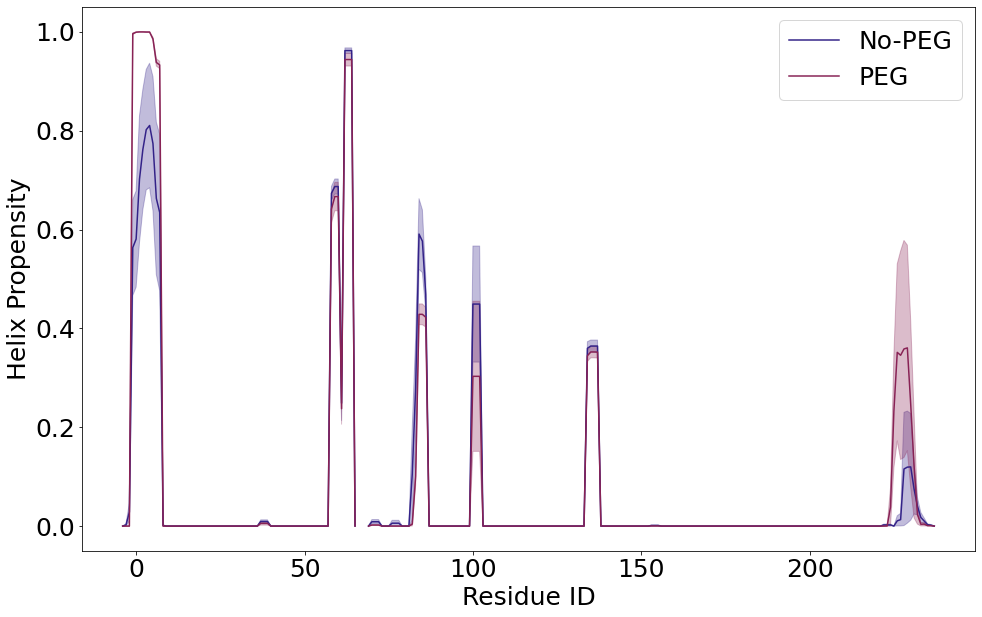

In [11]:
system_helicity = []
sem_helicity = []
for i in range(len(helicity)):
    system_helicity.append(mean(helicity[i],axis = 0))
    sem_helicity.append(scipy.stats.sem(helicity[i],axis = 0))

system_helicity_withnans=[]
sem_helicity_withnans=[]
for i in range(len(system_helicity)):
    
    test=system_helicity[i]
    test_sem=sem_helicity[i]
    test_put_in_nans=[]
    test_sem_put_in_nans=[]
    for j in range(70):
        test_put_in_nans.append(test[j])
        test_sem_put_in_nans.append(test_sem[j])
    test_put_in_nans.append(nan)
    test_put_in_nans.append(nan)
    test_put_in_nans.append(nan)
    test_sem_put_in_nans.append(nan)
    test_sem_put_in_nans.append(nan)
    test_sem_put_in_nans.append(nan)
    for j in range(70,len(test)):
        test_put_in_nans.append(test[j])    
        test_sem_put_in_nans.append(test_sem[j])    
    system_helicity_withnans.append(array(test_put_in_nans)) 
    sem_helicity_withnans.append(array(test_sem_put_in_nans))
figure(figsize = (16,10))

plot(resids_mdtraj,system_helicity_withnans[0],color = colourScheme[0],label = system_names[0])
plot(resids_mdtraj,system_helicity_withnans[1],color = colourScheme[1],label = system_names[1])
fill_between(resids_mdtraj,system_helicity_withnans[0] - sem_helicity_withnans[0],system_helicity_withnans[0]+sem_helicity_withnans[0],color = colourScheme[0],alpha = 0.3)
fill_between(resids_mdtraj,system_helicity_withnans[1] - sem_helicity_withnans[1],system_helicity_withnans[1]+sem_helicity_withnans[1],color = colourScheme[1],alpha = 0.3)

xlabel("Residue ID",fontsize = 25)
ylabel("Helix Propensity",fontsize = 25)
xticks(fontsize = 25)
yticks(fontsize = 25)
legend(fontsize = 25)

#savefig("system_helicity.png",dpi = 600)


In [14]:
save("system_helicity_withnans.npy",system_helicity_withnans)
save("sem_helicity_withnans.npy",sem_helicity_withnans)

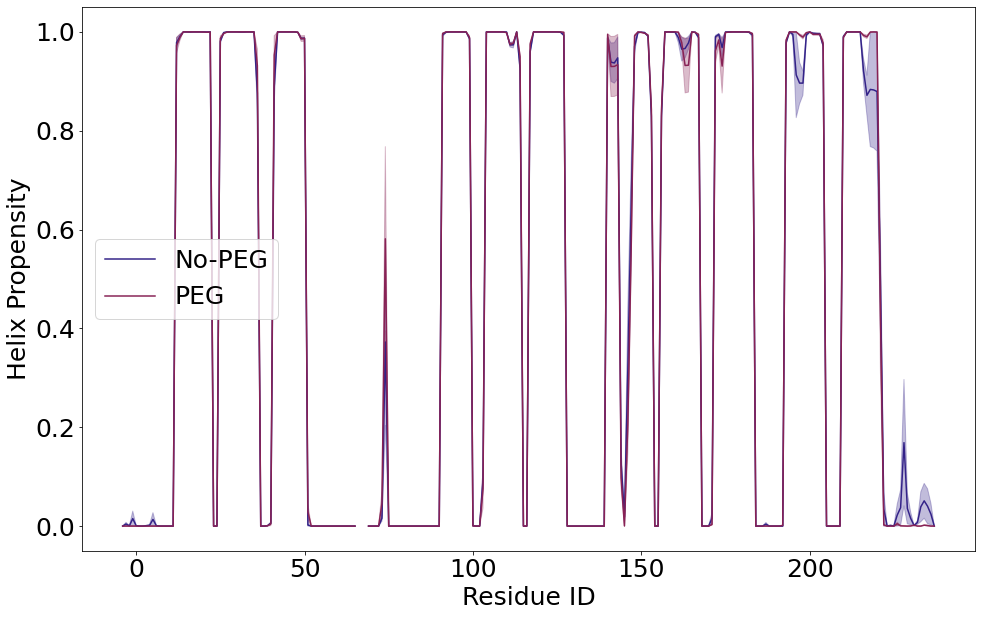

In [12]:
system_betacity = []
sem_betacity = []
for i in range(len(betacity)):
    system_betacity.append(mean(betacity[i],axis = 0))
    sem_betacity.append(scipy.stats.sem(betacity[i],axis = 0))

system_betacity_withnans=[]
sem_betacity_withnans=[]
for i in range(len(system_betacity)):
    
    test=system_betacity[i]
    test_sem=sem_betacity[i]
    test_put_in_nans=[]
    test_sem_put_in_nans=[]
    for j in range(70):
        test_put_in_nans.append(test[j])
        test_sem_put_in_nans.append(test_sem[j])
    test_put_in_nans.append(nan)
    test_put_in_nans.append(nan)
    test_put_in_nans.append(nan)
    test_sem_put_in_nans.append(nan)
    test_sem_put_in_nans.append(nan)
    test_sem_put_in_nans.append(nan)
    for j in range(70,len(test)):
        test_put_in_nans.append(test[j])    
        test_sem_put_in_nans.append(test_sem[j])    
    system_betacity_withnans.append(array(test_put_in_nans)) 
    sem_betacity_withnans.append(array(test_sem_put_in_nans))
figure(figsize = (16,10))

plot(resids_mdtraj,system_betacity_withnans[0],color = colourScheme[0],label = system_names[0])
plot(resids_mdtraj,system_betacity_withnans[1],color = colourScheme[1],label = system_names[1])
fill_between(resids_mdtraj,system_betacity_withnans[0] - sem_betacity_withnans[0],system_betacity_withnans[0]+sem_betacity_withnans[0],color = colourScheme[0],alpha = 0.3)
fill_between(resids_mdtraj,system_betacity_withnans[1] - sem_betacity_withnans[1],system_betacity_withnans[1]+sem_betacity_withnans[1],color = colourScheme[1],alpha = 0.3)

xlabel("Residue ID",fontsize = 25)
ylabel("Beta Propensity",fontsize = 25)
xticks(fontsize = 25)
yticks(fontsize = 25)
legend(fontsize = 25)

#savefig("system_betacity.png",dpi = 600)


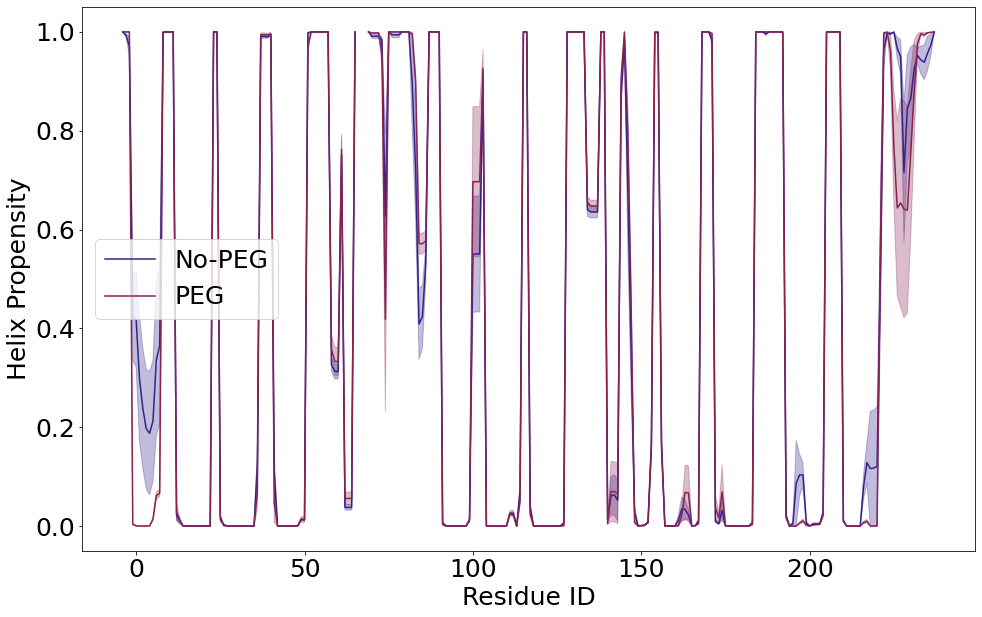

In [13]:
system_coilicity = []
sem_coilicity = []
for i in range(len(coilicity)):
    system_coilicity.append(mean(coilicity[i],axis = 0))
    sem_coilicity.append(scipy.stats.sem(coilicity[i],axis = 0))

system_coilicity_withnans=[]
sem_coilicity_withnans=[]
for i in range(len(system_coilicity)):
    
    test=system_coilicity[i]
    test_sem=sem_coilicity[i]
    test_put_in_nans=[]
    test_sem_put_in_nans=[]
    for j in range(70):
        test_put_in_nans.append(test[j])
        test_sem_put_in_nans.append(test_sem[j])
    test_put_in_nans.append(nan)
    test_put_in_nans.append(nan)
    test_put_in_nans.append(nan)
    test_sem_put_in_nans.append(nan)
    test_sem_put_in_nans.append(nan)
    test_sem_put_in_nans.append(nan)
    for j in range(70,len(test)):
        test_put_in_nans.append(test[j])    
        test_sem_put_in_nans.append(test_sem[j])    
    system_coilicity_withnans.append(array(test_put_in_nans)) 
    sem_coilicity_withnans.append(array(test_sem_put_in_nans))
figure(figsize = (16,10))

plot(resids_mdtraj,system_coilicity_withnans[0],color = colourScheme[0],label = system_names[0])
plot(resids_mdtraj,system_coilicity_withnans[1],color = colourScheme[1],label = system_names[1])
fill_between(resids_mdtraj,system_coilicity_withnans[0] - sem_coilicity_withnans[0],system_coilicity_withnans[0]+sem_coilicity_withnans[0],color = colourScheme[0],alpha = 0.3)
fill_between(resids_mdtraj,system_coilicity_withnans[1] - sem_coilicity_withnans[1],system_coilicity_withnans[1]+sem_coilicity_withnans[1],color = colourScheme[1],alpha = 0.3)

xlabel("Residue ID",fontsize = 25)
ylabel("Coil Propensity",fontsize = 25)
xticks(fontsize = 25)
yticks(fontsize = 25)
legend(fontsize = 25)

#savefig("system_coilicity.png",dpi = 600)
